In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 

#some of the data is on pangeo gcp, some on AWS
import sys

icloud = 0  #0 is local 1 is on pangeo

if icloud==1:
    import intake
    import dask
    import dask.array as dsa
    import gcsfs
    import fsspec
    adir = './../data/' 
    sys.path.append('/home/jovyan/cloud_science/subroutines/')  #where your
    from get_data_pangeo import get_data
else: 
    adir = 'f:/data/project_data/NASA_biophysical/collocated_data/'
    sys.path.append('./../cloud_science/subroutines/')  #where your
    from get_data_local import get_data
    
#list of input files
filename_origin=adir + 'NPPSD_GOA_allseabird_full_eddy_info.nc'
# output files
filename_origin_out=adir + 'NPPSD_GOA_allseabird_full_eddy_info_envdata'

In [ ]:
if icloud == 1:
    #libs for dask gateway
    from dask_gateway import Gateway
    from dask.distributed import Client
    gateway = Gateway()
    cluster = gateway.new_cluster()
    #cluster.adapt(minimum=1, maximum=200)
    cluster.scale(50)
    client = Client(cluster)
    cluster

In [12]:
ctype = 'CPR'
ds_bird = xr.open_dataset(filename_origin)
ds_bird['time'] = ds_bird.time64 if ctype=='goa' else print('fine')
#p = [q.index(v) if v in q else 99999 for v in vm]
#if not ctype=='CPR' 
#ds_bird['lon'] = (ds_bird['lon'] + 180) % 360 - 180

fine


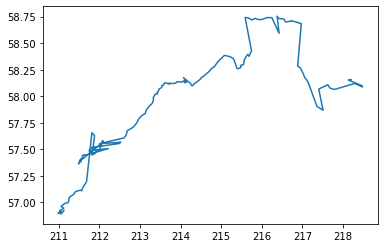

In [6]:
plt.plot(ds_bird.lon[0,:],ds_bird.lat[0,:])

In [ ]:
ilen_bird1 = len(ds_bird.track)
ilen_bird2 = len(ds_bird.observation_number)
for name in data:
    ds_data=data[name]
    print('data',name)
    if (name=='aviso'): # or (name=='wnd') or (name=='color') or:
       continue
    for var in ds_data:
        var_tem=var
        ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    if name=='topo':
        temlat,temlon = ds_bird.lat.fillna(0),ds_bird.lon.fillna(0)
        tem2=ds_data.etopo_depth.interp(lat=temlat,lon=temlon,method='nearest') 
        ds['etopo_depth']=xr.DataArray(tem2.data, coords={'track': ds_bird.track}, dims=('track'))
        ds['etopo_depth'].attrs = ds_data.attrs
    else:
        dtvar = np.timedelta64(9,'h') if name=='sst' else np.timedelta64(0,'h')   # if MUR SST need to change to 9am
        tem = ds_data.interp(time=ds_bird.time64+dtvar,lat=ds_bird.lat,lon=ds_bird.lon)
        tem = tem.load()
        for var in ds_data:
            var_tem=var
            ds_bird[var_tem][:,:]=tem[var].data
    #output data
    ds_bird.to_netcdf(filename_origin_out+name+'.nc')
    print('output:',filename_origin_out+name+'.nc')

In [ ]:
##color
input_data = 'color'
ilen_bird1 = len(ds_bird.track)
ilen_bird2 = len(ds_bird.observation_number)
for name in data:
    ds_data=data[name]
    if not name==input_data:
        continue
    print('name',name)   
    for var in ds_data:
        var_tem=var #ds_data[var].attrs['var_name']
        ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(ilen_bird1):
        for j in range(10):#ilen_bird2):
            if np.isnan(ds_bird.lat[i,j]):
                continue
            if ds_bird.time[i,j]<ds_data.time.min():
                continue
            if ds_bird.time[i,j]>ds_data.time.max():
                continue
            t1,t2 = ds_bird.time[i,j]-np.timedelta64(4,'D'), ds_bird.time[i,j]+np.timedelta64(4,'D')
            lat1,lat2=ds_bird.lat[i,j]+.5,ds_bird.lat[i,j]-.5
            lon1,lon2=ds_bird.lon[i,j]-.5,ds_bird.lon[i,j]+.5
#            tem = ds_data.sel(time=str(ds_bird.time[i,j].data)[0:10],method='nearest')
            tem = ds_data.sel(time=slice(t1,t2)).mean(dim='time',keep_attrs=True,skip_nan=True)
            tem = tem.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
            tem = tem.interp(lat=ds_bird.lat[i,j],lon=ds_bird.lon[i,j])
            for var in ds_data:
                var_tem=var #ds_data[var].attrs['var_name']
                ds_bird[var_tem][i,j]=tem[var].data
        print(i,ilen_bird1)
    #df_bird = ds_bird.to_dataframe()
    ds_bird.to_netcdf(filename_origin_out+name+'.nc')
    print('output:',filename_origin_out+name+'.nc')

In [ ]:
import glob 
#put it all together and create a csv file
print(filename_origin_out)
#filename = glob.glob('f:/data/project_data/NASA_biophysical/collocated_data/'+filename_origin_out+'*.nc')
filename = glob.glob('f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info_envdata*.nc')
filename = filename[1:]
filename


In [ ]:
print(filename[0])
ds = xr.open_dataset(filename[0])
for iname in range(1,len(filename)):
    print(filename[iname])
    ds2 = xr.open_dataset(filename[iname])
    for var in ds2:
        if not var in ds:
            ds[var]=ds2[var]
                
ds.to_netcdf(filename_origin_out+'all'+'.nc')
df_bird = ds.to_dataframe()
df_bird.to_csv(filename_origin_out+'all'+'.csv')


In [ ]:

#point by point collocaiton OLD
ilen_bird1 = len(ds_bird.track)
ilen_bird2 = len(ds_bird.observation_number)
for name in data:
    ds_data=data[name]
    if name=='topo':
        continue
    if name=='color':
        continue
    #if not name==input_data:
    #    continue
    print('name',name)   
    for var in ds_data:
        var_tem=var #ds_data[var].attrs['var_name']
        ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(ilen_bird1):
        for j in range(10):#ilen_bird2):
            if np.isnan(ds_bird.lat[i,j]):
                continue
            if ds_bird.time[i,j]<ds_data.time.min():
                continue
            if ds_bird.time[i,j]>ds_data.time.max():
                continue
            t1,t2 = ds_bird.time[i,j]-np.timedelta64(24,'h'), ds_bird.time[i,j]+np.timedelta64(24,'h')
            lat1,lat2=ds_bird.lat[i,j]-.5,ds_bird.lat[i,j]+.5
            lon1,lon2=ds_bird.lon[i,j]-.5,ds_bird.lon[i,j]+.5
            tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
            tem = tem.interp(time=ds_bird.time[i,j],lat=ds_bird.lat[i,j],lon=ds_bird.lon[i,j])
            for var in ds_data:
                var_tem=ds_data[var].attrs['var_name']
                ds_bird[var_tem][i,j]=tem[var].data
        print(i,ilen_bird1)
    #df_bird = ds_bird.to_dataframe()
    ds_bird.to_netcdf(filename_origin_out+name+'.nc')
ds_bird.to_netcdf(filename_origin_out+'all'+'.nc')


# trying to do topo 
- but lots of nan becuase of array construct

In [ ]:
ds_topo=data['topo']
new_lat = xr.DataArray(ds_bird.lat.values, dims=('new_dim1','new_dims2')).fillna(0)
new_lon = xr.DataArray(ds_bird.lon.values, dims=('new_dim1','new_dims2')).fillna(0)
tem2 = ds_topo.z.interp(lat=new_lat, lon=new_lon,method='nearest')
ds_bird['ETOPO_depth'] = xr.DataArray(tem2.data, 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
ds_bird['ETOPO_depth']=np.where(np.isnan(ds_bird.lat),np.nan,ds_bird['ETOPO_depth'])


In [ ]:
ds_bird

In [ ]:
##topo
ds_topo=data['topo']
temlat = ds_bird.lat
temlon = ds_bird.lon
temlat = temlat.fillna(0)
temlon = temlon.fillna(0)
tem2=ds_topo.z.interp(lat=temlat,lon=temlon,method='nearest') 
#ds_bird['ETOPO_depth']